In [23]:
import tensorflow as tf
import os

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# Avoid OOM (Out of Memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
print(f"GPUs Setup: {len(gpus)}")

GPUs Setup: 1


Image processing

In [2]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [3]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))


In [4]:
data = tf.keras.utils.image_dataset_from_directory('data') # Keras built in dataset creation

Found 156 files belonging to 2 classes.


I0000 00:00:1767197898.507204   14398 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
data_iterator = data.as_numpy_iterator() # Cannot iterate through keras created dataset so have to convert it to a numpy iterator

In [6]:
# Get another batch from iterator
batch = data_iterator.next()

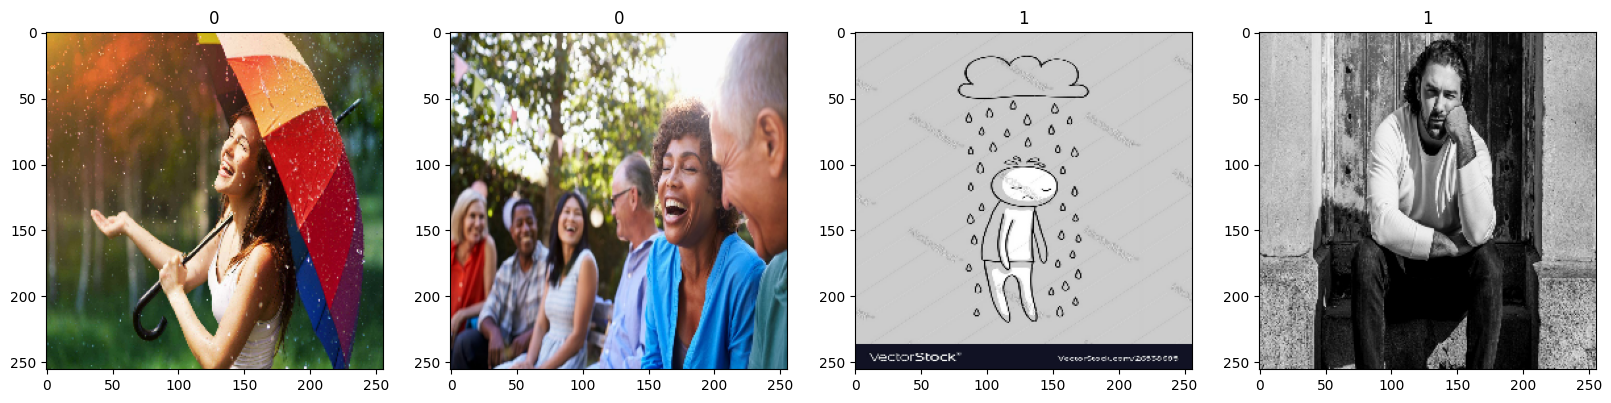

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Class 1 = sad people, Class 0 = happy people

Data Processing

In [8]:
data = data.map(lambda x, y:(x/255,y)) # reducing values from 0 to 255, to 0 to 1. Faster processing

In [9]:
scaled_batch = data.as_numpy_iterator()
scaled_batch.next()[0].min()


np.float32(0.0)

In [10]:
# Split data

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1


In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Building the network

In [13]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu',))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu',))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/mnt/c/Users/sabee/OneDrive/Desktop/Programming/Python/AI-ML/Deep Learning/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Model Training

In [16]:
logdir = 'logs'

In [17]:
tensor_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensor_callback])

Epoch 1/20


2025-12-31 21:48:30.651822: I external/local_xla/xla/service/service.cc:163] XLA service 0x769ed0003d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-31 21:48:30.651942: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-31 21:48:31.022798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-31 21:48:31.889371: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2025-12-31 21:48:32.034639: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-31 21:48:33.

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5312 - loss: 1.3407 - val_accuracy: 0.4375 - val_loss: 2.0602
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 664ms/step - accuracy: 0.5208 - loss: 1.2599 - val_accuracy: 0.5312 - val_loss: 0.7019
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 558ms/step - accuracy: 0.5833 - loss: 0.6838 - val_accuracy: 0.5312 - val_loss: 0.6180
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.6562 - loss: 0.5570 - val_accuracy: 0.5938 - val_loss: 0.6056
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 648ms/step - accuracy: 0.7083 - loss: 0.5854 - val_accuracy: 0.8750 - val_loss: 0.4458
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 580ms/step - accuracy: 0.7500 - loss: 0.5392 - val_accuracy: 0.8125 - val_loss: 0.4613
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.8333 - loss: 0.4467 - val_accuracy: 0.8438 - val_loss: 0.4186
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 618ms/step - accuracy: 0.8750 - loss: 0.3603 - val_accuracy: 0.7500 - val_loss: 0.4402
Epoch

2025-12-31 21:49:03.930305: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - accuracy: 0.8438 - loss: 0.3608 - val_accuracy: 0.8438 - val_loss: 0.4196
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8611 - loss: 0.3412 

2025-12-31 21:49:07.888343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 683ms/step - accuracy: 0.8333 - loss: 0.3627 - val_accuracy: 0.8750 - val_loss: 0.3267
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 759ms/step - accuracy: 0.8438 - loss: 0.3227 - val_accuracy: 0.9688 - val_loss: 0.2059
Epoch 12/20


2025-12-31 21:49:09.692437: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step - accuracy: 0.9375 - loss: 0.2746 - val_accuracy: 1.0000 - val_loss: 0.2289
Epoch 13/20


2025-12-31 21:49:11.963111: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 867ms/step - accuracy: 0.9479 - loss: 0.2283 - val_accuracy: 0.9062 - val_loss: 0.3102
Epoch 14/20


2025-12-31 21:49:13.913221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.9167 - loss: 0.2153 - val_accuracy: 0.9688 - val_loss: 0.1585
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.9583 - loss: 0.1755 - val_accuracy: 0.9688 - val_loss: 0.1696
Epoch 16/20


2025-12-31 21:49:18.129393: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 668ms/step - accuracy: 0.9688 - loss: 0.1437 - val_accuracy: 1.0000 - val_loss: 0.0990
Epoch 17/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 570ms/step - accuracy: 0.9896 - loss: 0.0935 - val_accuracy: 0.9688 - val_loss: 0.1336
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 835ms/step - accuracy: 1.0000 - loss: 0.0746 - val_accuracy: 1.0000 - val_loss: 0.0437
Epoch 19/20


2025-12-31 21:49:31.546916: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166336 bytes after encountering the first element of size 25166336 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step - accuracy: 0.9896 - loss: 0.0922 - val_accuracy: 1.0000 - val_loss: 0.0262
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9809 - loss: 0.0528

2025-12-31 21:49:35.379399: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 861ms/step - accuracy: 0.9896 - loss: 0.0472 - val_accuracy: 1.0000 - val_loss: 0.0357


Plotting Performance

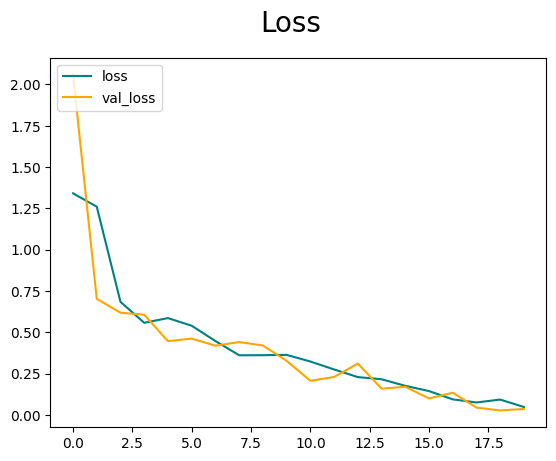

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

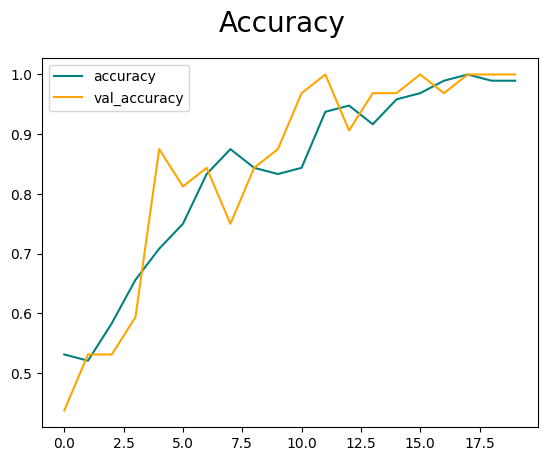

In [20]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Performance Evaluation

In [25]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch 
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Precision: 1.0, Recall: 1.0, Accuracy: 1.0


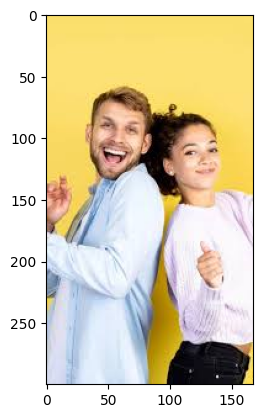

In [27]:
img = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

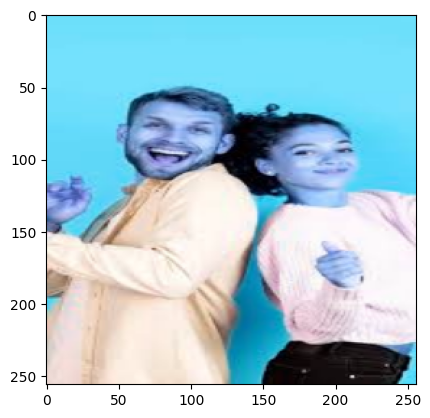

In [29]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()